In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import xgboost as xgb

import joblib

os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
df = pd.read_csv('melb_data.csv')
df.head(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
5,Abbotsford,129 Charles St,2,h,941000.0,S,Jellis,7/05/2016,2.5,3067.0,...,1.0,0.0,181.0,NaN,NaN,Yarra,-37.8041,144.9953,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,1.0,0.0,NaN,NaN,Yarra,-37.8008,144.9973,Northern Metropolitan,4019.0
9,Abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,8/10/2016,2.5,3067.0,...,1.0,2.0,220.0,75.0,1900.0,Yarra,-37.8010,144.9989,Northern Metropolitan,4019.0


In [3]:
df = df.dropna()
print(df.isnull().sum())
print(df.describe)

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64
<bound method NDFrame.describe of              Suburb          Address  Rooms Type      Price Method  \
1        Abbotsford  25 Bloomburg St      2    h  1035000.0      S   
2        Abbotsford     5 Charles St      3    h  1465000.0     SP   
4        Abbotsford      55a Park St      4    h  1600000.0     VB   
6        Abbotsford     124 Yarra St      3    h  1876000.0      S   
7        Abbotsford    98 Charles St      2    h  1636000.0      S   
...             ...              ...    ...  ...        ...    ...   
12205    Whittlesea    30 Sherwin St      3    h   601000.0     

In [4]:
print(df.describe().apply(lambda s: s.apply('{0:.5f}'.format)))

            Rooms          Price    Distance    Postcode    Bedroom2  \
count  6196.00000     6196.00000  6196.00000  6196.00000  6196.00000   
mean      2.93141  1068828.20207     9.75110  3101.94771     2.90203   
std       0.97108   675156.42750     5.61207    86.42160     0.97005   
min       1.00000   131000.00000     0.00000  3000.00000     0.00000   
25%       2.00000   620000.00000     5.90000  3044.00000     2.00000   
50%       3.00000   880000.00000     9.00000  3081.00000     3.00000   
75%       4.00000  1325000.00000    12.40000  3147.00000     3.00000   
max       8.00000  9000000.00000    47.40000  3977.00000     9.00000   

         Bathroom         Car     Landsize BuildingArea   YearBuilt  \
count  6196.00000  6196.00000   6196.00000   6196.00000  6196.00000   
mean      1.57634     1.57360    471.00694    141.56864  1964.08199   
std       0.71136     0.92995    897.44988     90.83482    38.10567   
min       1.00000     0.00000      0.00000      0.00000  1196.00000

In [5]:
y = df.Price
df_features = ["Rooms", "Bedroom2", "Bathroom", "Landsize", "BuildingArea", "YearBuilt", "Lattitude", "Longtitude"]
X = df[df_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(random_state=1)

In [6]:
# Tar runt 4min

param_grid = {
"n_estimators": [150, 200, 1000],
"max_depth": [3, 5, 10, 11, 13, 15],
"min_samples_split": [1, 2, 3, 5],
"min_samples_leaf": [1, 2, 3, 5],
"bootstrap": [True, False],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
joblib.dump(best_model, 'best_random_forest_model.pkl')
joblib.dump(best_params, 'best_random_forest_params.pkl')


'\nparam_grid = {\n"n_estimators": [150, 200, 1000],\n"max_depth": [3, 5, 10, 11, 13, 15],\n"min_samples_split": [1, 2, 3, 5],\n"min_samples_leaf": [1, 2, 3, 5],\n"bootstrap": [True, False],\n}\n\ngrid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)\ngrid_search.fit(X_train, y_train)\n\nprint(grid_search.best_params_)\n\nbest_model = grid_search.best_estimator_\nbest_params = grid_search.best_params_\njoblib.dump(best_model, \'best_random_forest_model.pkl\')\njoblib.dump(best_params, \'best_random_forest_params.pkl\')\n'

In [7]:
loaded_model = joblib.load('best_random_forest_model.pkl')
loaded_params = joblib.load('best_random_forest_params.pkl')
y_pred = loaded_model.predict(X_test)



c:\Users\rasmu\Desktop\VSCode\AI-kurs\gruppuppgifter\uppgift6\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\rasmu\Desktop\VSCode\AI-kurs\gruppuppgifter\uppgift6\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Hyperparameters: {loaded_params}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2):{r2}")

Best Hyperparameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Mean Squared Error (MSE): 77781688909.6405
Root Mean Squared Error (RMSE): 278893.68746825465
R-squared (R2):0.8254013439498558


In [9]:
cv_score = cross_val_score (rf, X_train,y_train, cv = 5)
print("Score ",cv_score)
print("Accuracy",cv_score.mean())


Score  [0.68540743 0.80525389 0.7615275  0.84513585 0.83204603]
Accuracy 0.7858741373152418


BuildingArea: 0.43601361200147254
Lattitude: 0.17005494114056094
YearBuilt: 0.14215244288145093
Longtitude: 0.13302172634349854
Landsize: 0.07680100245802234
Bathroom: 0.02177316206855288
Rooms: 0.011635095146392839
Bedroom2: 0.008548017960049023


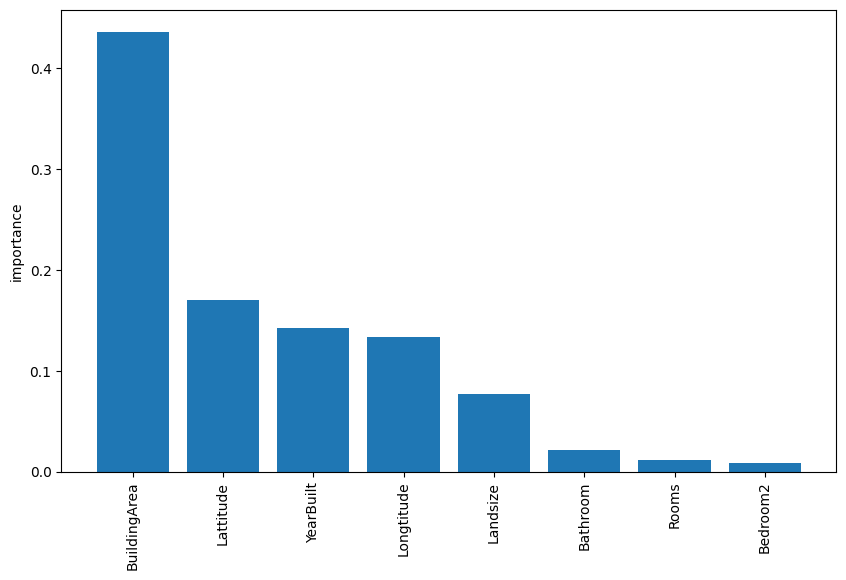

In [10]:
importances = loaded_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")

plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align = "center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation = 90)
plt.ylabel("importance")
plt.show()

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

In [11]:
# Current:
# Tar runt 4 min 30sec

# Tar runt 62+ min
# Fitting 5 folds for each of 5832 candidates, totalling 29160 fits

# Tar 381+ min
# Fitting 5 folds for each of 58320 candidates, totalling 291600 fits
param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    "gamma": [0, 0.1],
    "alpha": [0, 0.1],
    "lambda": [1, 1.5]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
best_xgb_params = grid_search.best_params_
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')
joblib.dump(best_xgb_params, 'best_xgb_params.pkl')

'\nparam_grid = {\n    \'n_estimators\': [1000],\n    \'learning_rate\': [0.01, 0.1],\n    \'max_depth\': [7, 8],\n    \'min_child_weight\': [1, 3],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0],\n    "gamma": [0, 0.1],\n    "alpha": [0, 0.1],\n    "lambda": [1, 1.5]\n}\n\nxgb_model = xgb.XGBRegressor(objective=\'reg:squarederror\', random_state=1)\n\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, \n                           cv=5, n_jobs=-1, verbose=2, scoring=\'neg_mean_absolute_error\')\n\ngrid_search.fit(X_train, y_train)\n\nprint("Best Params:", grid_search.best_params_)\n\nbest_xgb_model = grid_search.best_estimator_\nbest_xgb_params = grid_search.best_params_\njoblib.dump(best_xgb_model, \'best_xgb_model.pkl\')\njoblib.dump(best_xgb_params, \'best_xgb_params.pkl\')\n'

In [12]:
xgb_model = joblib.load('best_xgb_model.pkl')
xgb_params = joblib.load('best_xgb_params.pkl')
y_pred = xgb_model.predict(X_test)

In [13]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best Hyperparameters: {xgb_params}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2):{r2}")

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8}
Mean Squared Error (MSE): 71176293730.96901
Root Mean Squared Error (RMSE): 266788.8560846742
R-squared (R2):0.8402286527553503


BuildingArea: 0.2984241843223572
YearBuilt: 0.1327068954706192
Bathroom: 0.12724560499191284
Lattitude: 0.12293630093336105
Longtitude: 0.10033150762319565
Rooms: 0.09656796604394913
Bedroom2: 0.06552771478891373
Landsize: 0.05625978112220764


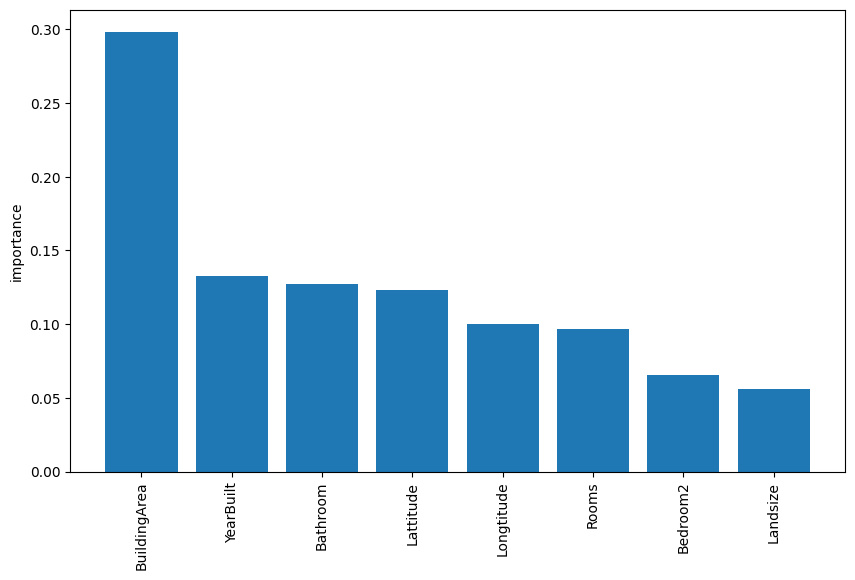

In [14]:
importances = xgb_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]
for i in range(X.shape[1]):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")

plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align = "center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation = 90)
plt.ylabel("importance")
plt.show()